Requirements:
- numpy
- scipy
- matplotlib
- ZoomFFT (install with ```pip install git+https://github.com/wavefrontshaping/zoomfft2d.git```)


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.colors import LogNorm

from functions import colorize, generate_reference, generate_complex_pattern
from zoomfft2d import ZoomFFT2D

# I. Generate syntetic data

## I.1. Generate complex pattern, reference

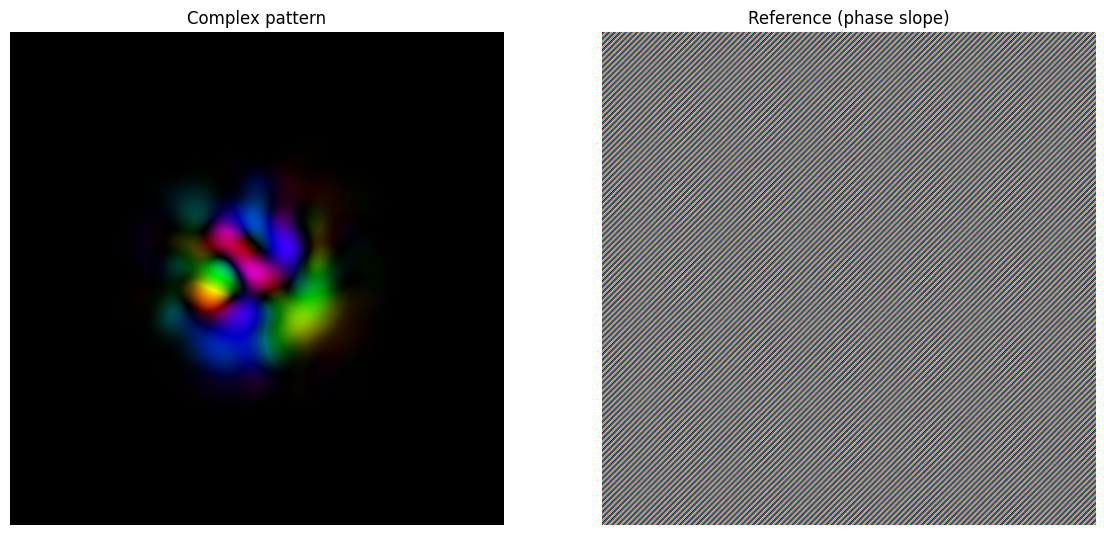

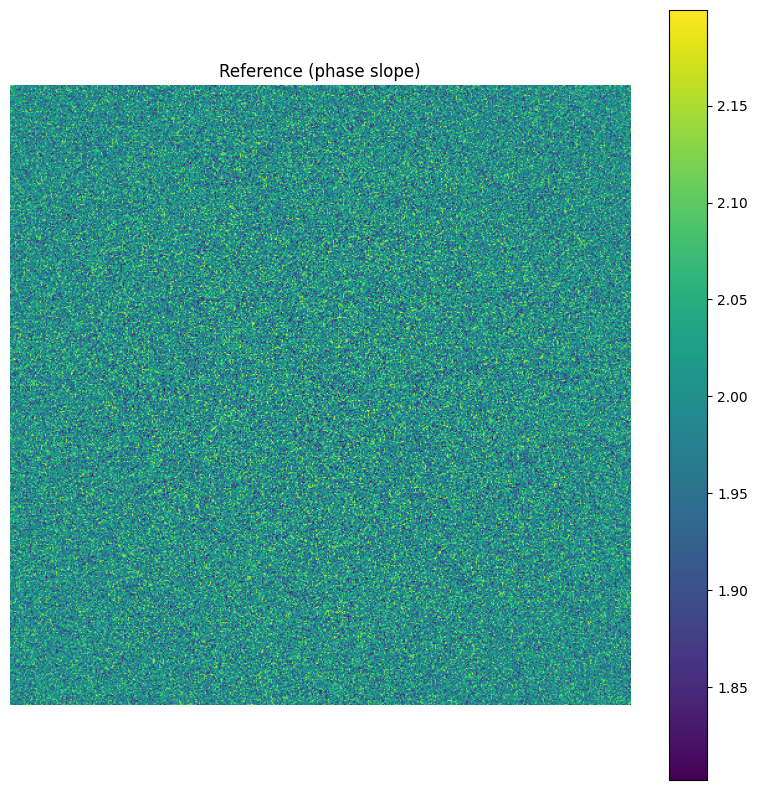

In [2]:
N = 500
# sigma of the pixel size (relative to the full window size)
sigma = 3e-2
# sigma of the envelope (relative to the full window size)
sigma_env = 0.2
# angle of the reference phase slope
angle = np.pi/4
# spatial frequency of the reference phase slope
fx, fy = 0.175,0.175
# SNR of the reference
SNR_ref = 1e1

sigma_noise = 3e-4
ref_amplitude = 2


complex_pattern, X, Y = generate_complex_pattern(N, sigma, sigma_env)
reference = generate_reference(X, Y, fx, fy)

## add some high-spatial frequency noise to the reference 
noise_reference, _, _ =  generate_complex_pattern(N, sigma_noise, 2.)

reference += 1/SNR_ref*noise_reference

reference *= ref_amplitude


plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(complex_pattern))
plt.axis('off')
plt.title('Complex pattern')
plt.subplot(122)
plt.imshow(colorize(reference))
plt.axis('off')
plt.title('Reference (phase slope)')


plt.figure(figsize=(10, 10))
plt.imshow(np.abs(reference))
plt.axis('off')
plt.title('Reference (phase slope)')
plt.colorbar()


## I.2. Compute interferogram

Text(0.5, 1.0, 'Off-axis interferogram')

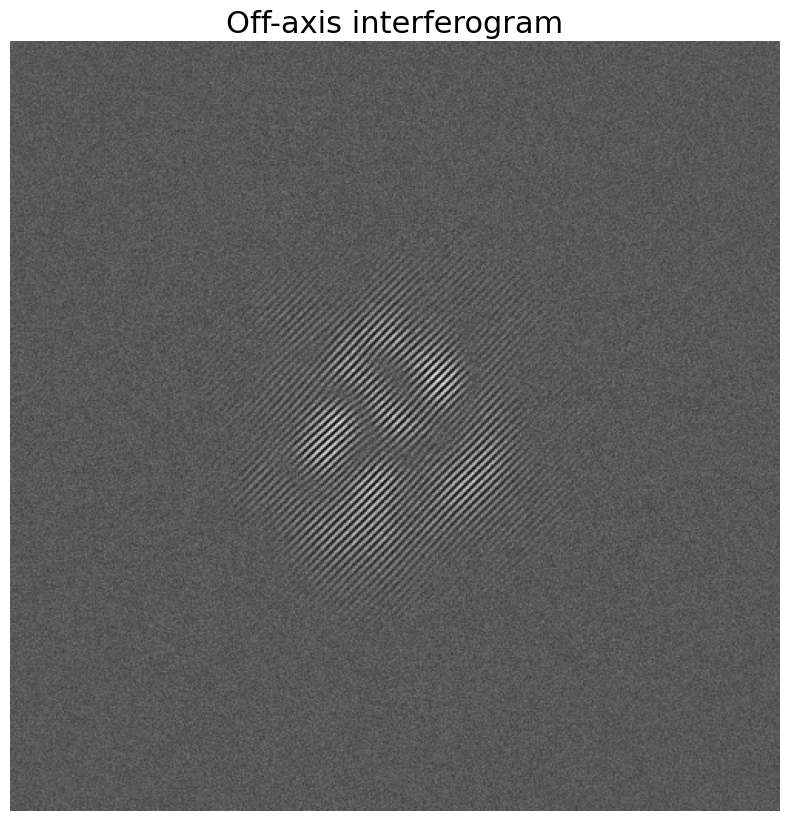

In [5]:
off_axis_intensity = np.abs(reference+complex_pattern)**2

plt.figure(figsize=(10, 10))
plt.imshow(np.abs(off_axis_intensity), cmap='gray')
plt.axis('off')
plt.title('Off-axis interferogram', fontsize = 22)

# II. Off-axis reconstruction

## II.1. Compute Fourier transform

(0.0, 0.0) (1.0, 1.0)


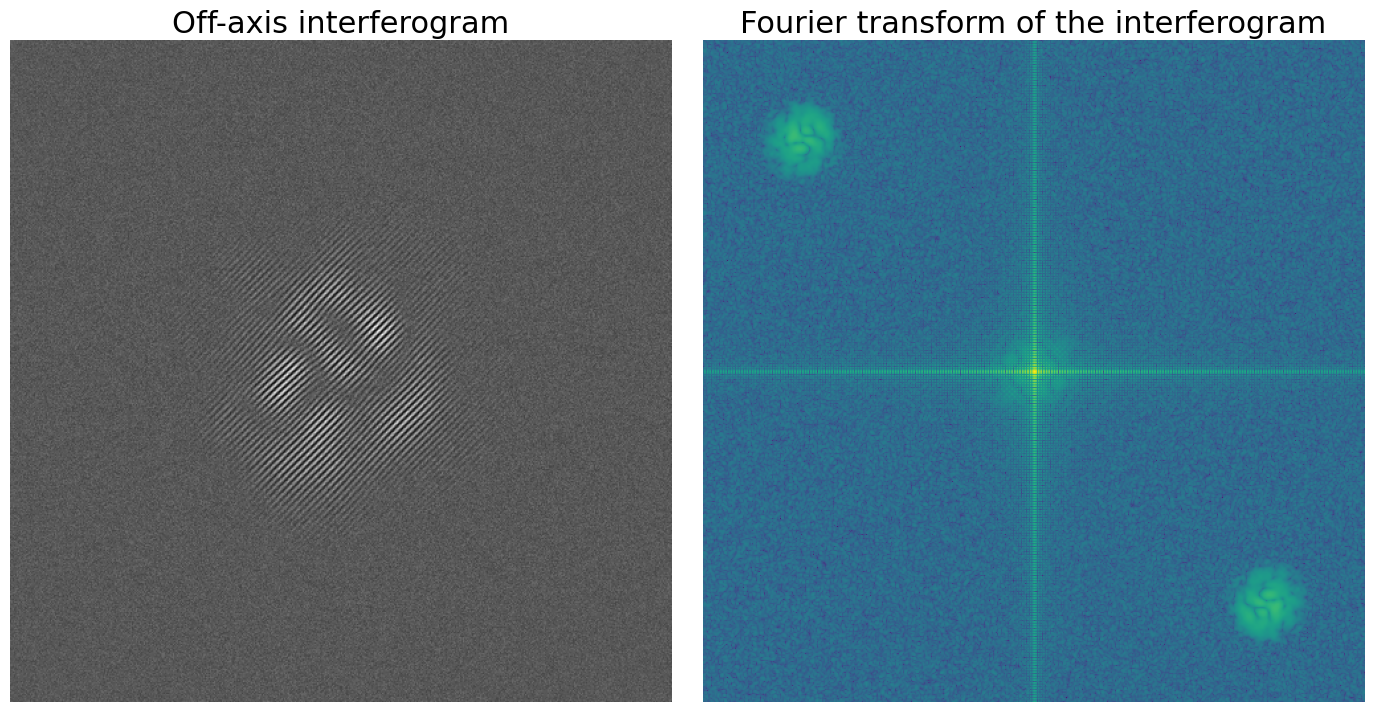

In [6]:


# Create the ZoomFFT object for the full FFT (slow!)
ft = ZoomFFT2D(off_axis_intensity.shape, off_axis_intensity.shape, 0., 1.)

# compute FFT of the interferogram
ft_img = ft(off_axis_intensity)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(off_axis_intensity, cmap = 'gray')
plt.axis('off')
plt.title('Off-axis interferogram', fontsize = 22)
plt.subplot(122)
plt.imshow(np.abs(ft_img)/np.max(np.abs(ft_img)),  norm=LogNorm(vmin=1e-6, vmax=1))
plt.axis('off')
plt.title('Fourier transform of the interferogram', fontsize = 22)
plt.tight_layout()
plt.show()

## II.2 Select the desired frequency window

[-0.35, -0.35] (0.1875, 0.1875)


Text(0.5, 1.0, 'Frequency window selected by the mask')

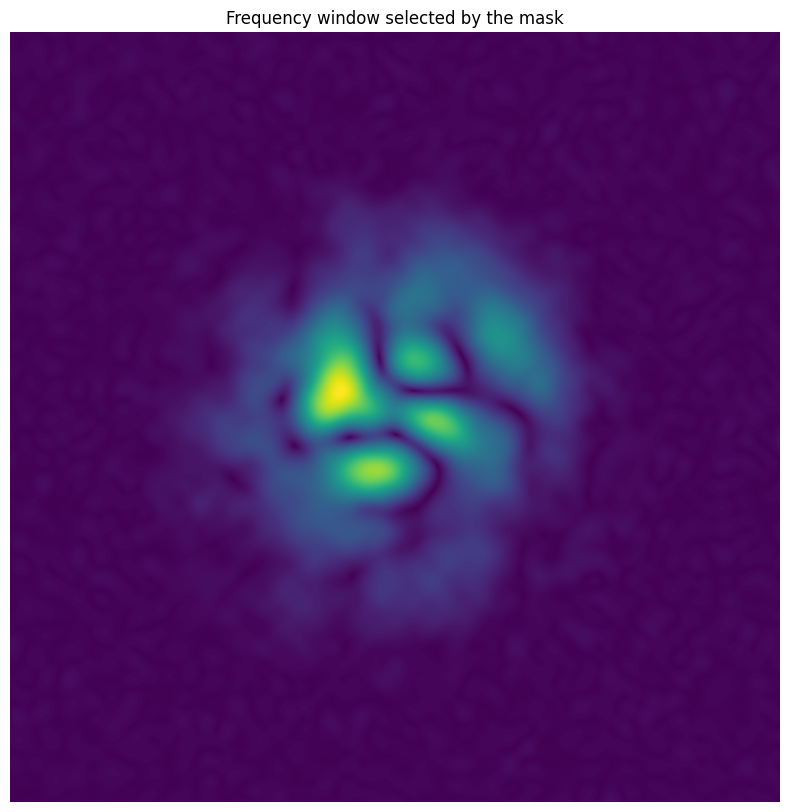

In [7]:
f_range = 0.075*2.5
ft_res = 1000
window_resolution = (ft_res, ft_res)


## Note that we take the minus sign to select the -1 order
## The +1 order contains the conjugate of the signal
f_center = (-fx, -fy)

ft_small = ZoomFFT2D(
    off_axis_intensity.shape, 
    window_resolution,
    f_center = f_center,
    f_range = f_range,
    )

ft_small_img = ft_small(off_axis_intensity)


plt.figure(figsize=(10, 10))
plt.imshow(np.abs(ft_small_img)/np.max(np.abs(ft_small_img)))
plt.axis('off')
plt.title('Frequency window selected by the mask')


## II.3. Inverse FT

In [8]:
if_range = N/ft_res*f_range


ift = ZoomFFT2D(
    ft_small_img.shape,
    off_axis_intensity.shape,
    f_center = 0.,
    f_range = if_range, 
    direction='backward'
    )


recovered_complex_pattern = ift(ft_small_img)

(0.0, 0.0) (0.09375, 0.09375)


## III. Results

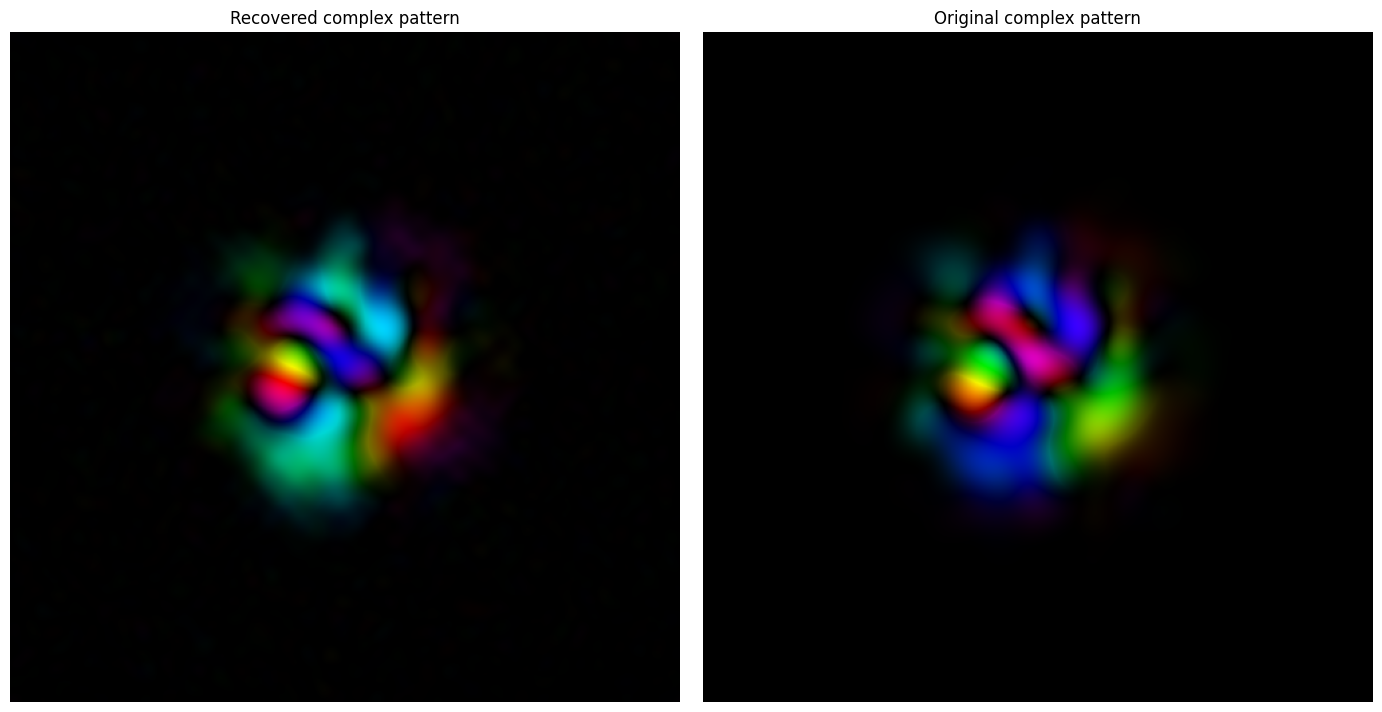

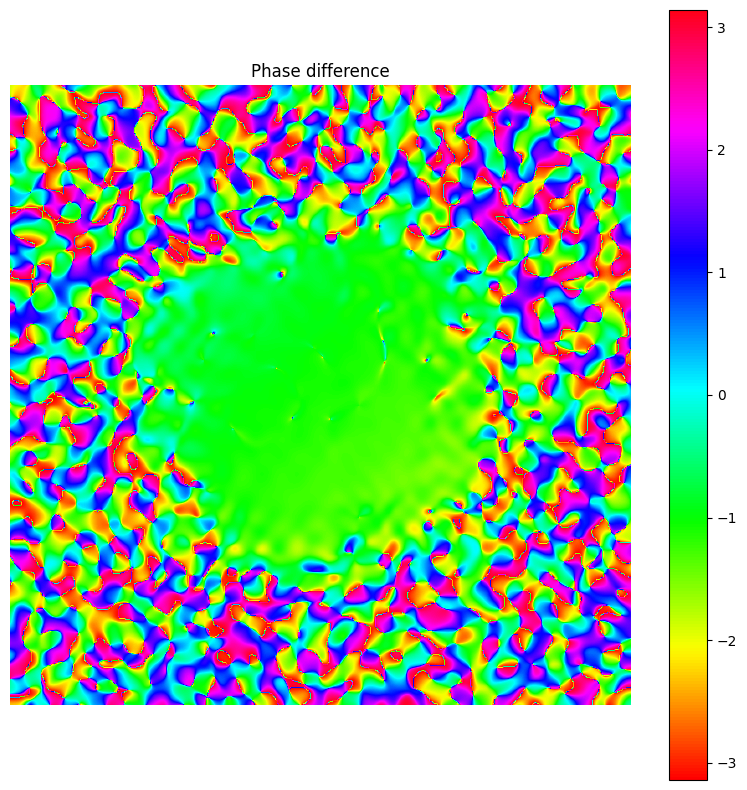

In [9]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow(colorize(recovered_complex_pattern))
plt.axis('off')
plt.title('Recovered complex pattern')
plt.subplot(122)
plt.imshow(colorize(complex_pattern))
plt.axis('off')
plt.title('Original complex pattern')
plt.tight_layout()

plt.figure(figsize=(10, 10))
plt.imshow(np.angle(recovered_complex_pattern/complex_pattern), cmap='hsv')
plt.axis('off')
plt.title('Phase difference')
plt.colorbar()


In [10]:
def abs_error(A,B):
    A = A/np.max(np.abs(A))
    B = B/np.max(np.abs(B))
    err = np.abs(np.abs(A)-np.abs(B))**2
    return err#/(np.abs(A)*np.abs(B))


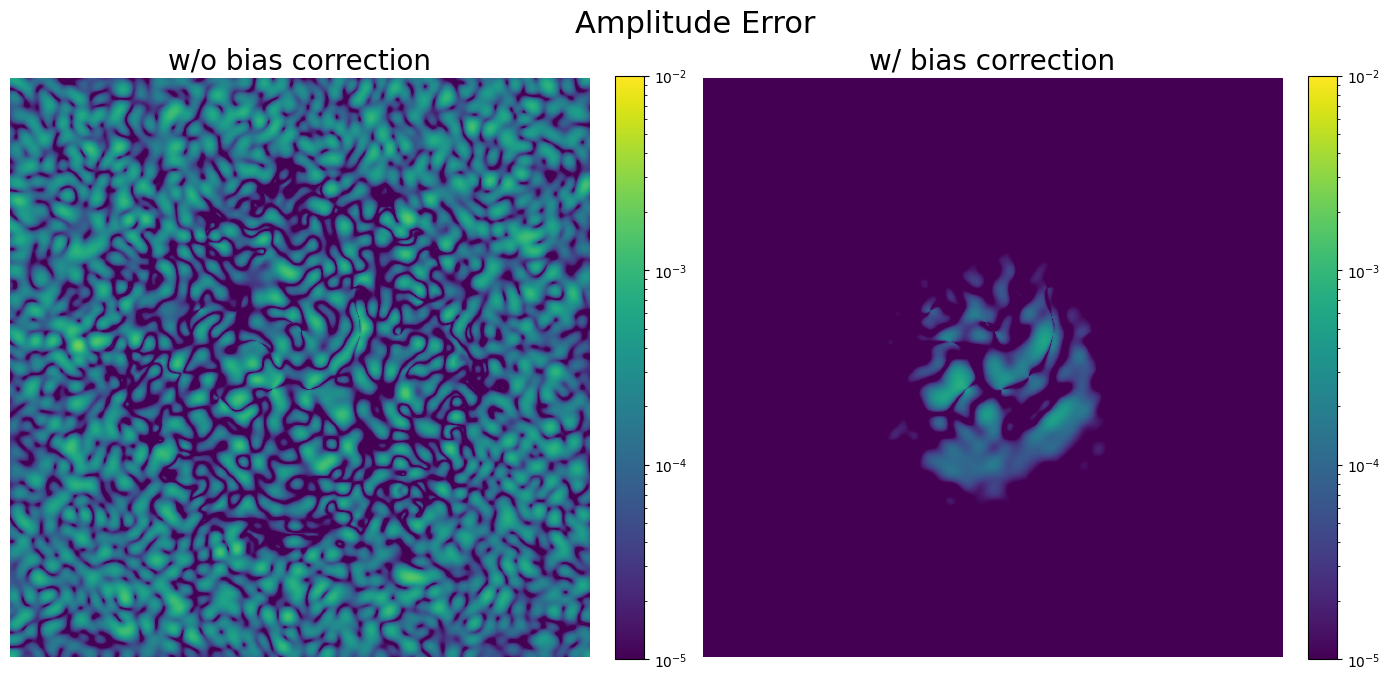

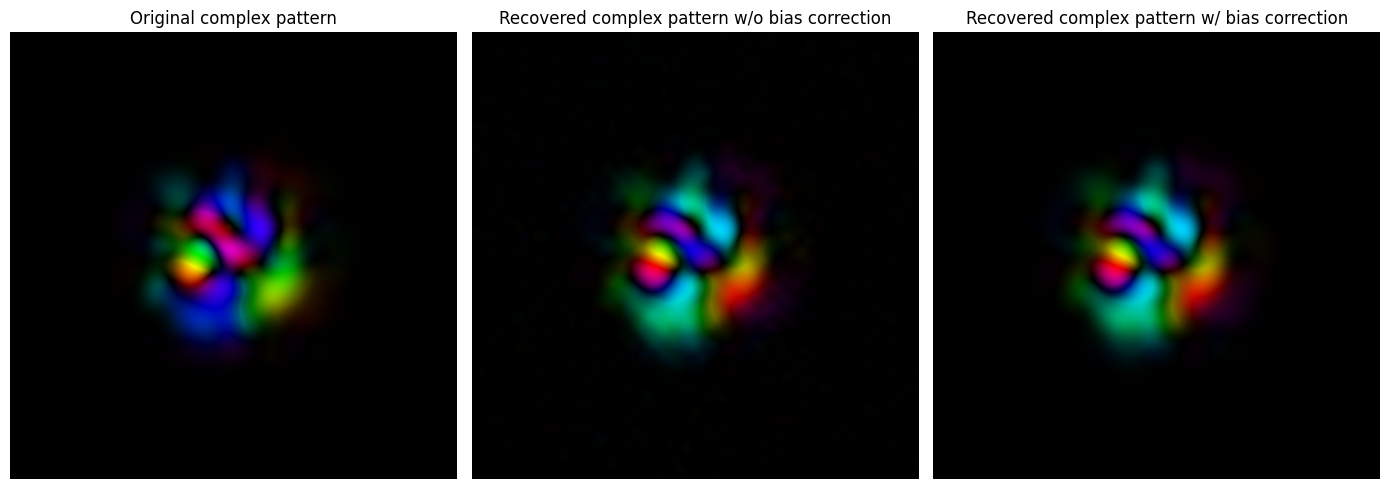

In [11]:
ft_small_ref = ft_small(np.abs(reference)**2)

# to recover the original pattern size, we need to set the f_range 
# in agreement with original size and the resolution of the zoomFFT window

recovered_complex_pattern_minus_bias = recovered_complex_pattern - ift(ft_small_ref)

# recovered_complex_pattern_minus_bias/= np.abs(reference)
vmax = 1e-2
vmin= 1e-5



plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.imshow((abs_error(recovered_complex_pattern,complex_pattern)), norm=LogNorm(vmin=vmin, vmax=vmax))
plt.axis('off')
plt.title('w/o bias correction', fontsize = 20)
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow((abs_error(recovered_complex_pattern_minus_bias,complex_pattern)), norm=LogNorm(vmin=vmin, vmax=vmax))
plt.axis('off')
plt.title('w/ bias correction', fontsize = 20)
plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle('Amplitude Error', fontsize = 22)
plt.tight_layout()



plt.figure(figsize=(14, 5))
plt.subplot(131)
plt.imshow(colorize(complex_pattern))
plt.axis('off')
plt.title('Original complex pattern')
# plt.colorbar()
plt.subplot(132)
plt.imshow(colorize(recovered_complex_pattern))
plt.axis('off')
plt.title('Recovered complex pattern w/o bias correction')

plt.tight_layout()
plt.subplot(133)
plt.imshow(colorize(recovered_complex_pattern_minus_bias))
plt.axis('off')
plt.title('Recovered complex pattern w/ bias correction')
plt.tight_layout()
